In [1]:
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import mglearn
%matplotlib inline

### 서포트 벡터 머신

#### 선형 모델과 비선형 특성

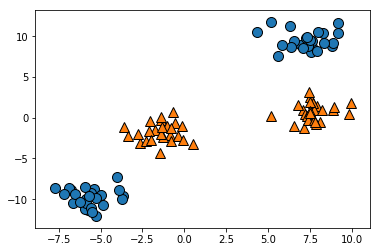

In [2]:
from sklearn.datasets import make_blobs

X, y = make_blobs(centers=4, random_state=8)
y %= 2

mglearn.discrete_scatter(X[:, 0], X[:, 1], y)

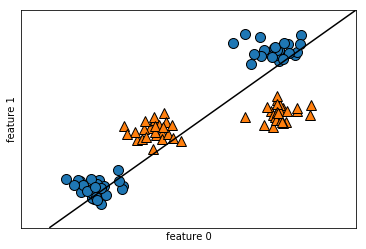

In [3]:
from sklearn.svm import LinearSVC
linear_svm = LinearSVC().fit(X, y)

mglearn.plots.plot_2d_separator(linear_svm, X)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel('feature 0')
plt.ylabel('feature 1')

선형 모델은 직선으로만 데이터 포인트를 나눌 수 있어서 이런 데이터 셋에서는 잘 들어 맞지 않는다
+ 두번째 특성을 제곱한 데이터를 추가

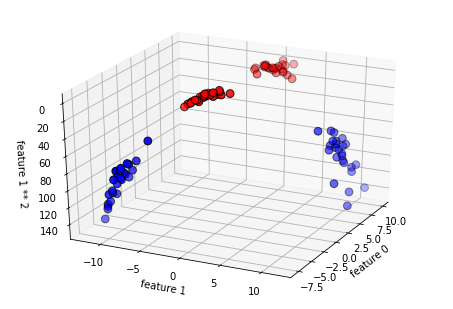

In [4]:
X_new = np.hstack([X, X[:, 1:] ** 2])

from mpl_toolkits.mplot3d import Axes3D, axes3d

figure = plt.figure()
ax = Axes3D(figure, elev=-152, azim=-26)
mask = y == 0

ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b', cmap=mglearn.cm2, s=60, edgecolor='k')
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', cmap=mglearn.cm2, s=60, edgecolor='k')
ax.set_xlabel('feature 0')
ax.set_ylabel('feature 1')
ax.set_zlabel('feature 1 ** 2')

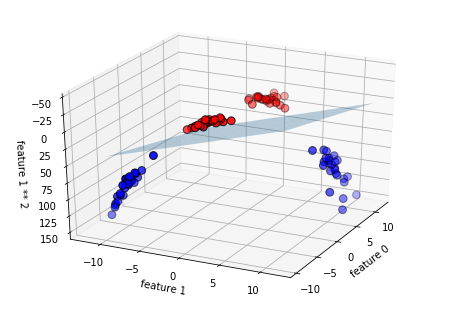

In [5]:
linear_svm_3d = LinearSVC().fit(X_new, y)
coef, intercept = linear_svm_3d.coef_.ravel(), linear_svm_3d.intercept_

figure = plt.figure()
ax = Axes3D(figure, elev=-152, azim=-26)
xx = np.linspace(X_new[:, 0].min() - 2, X_new[:, 0].max() + 2, 50)
yy = np.linspace(X_new[:, 0].min() - 2, X_new[:, 0].max() + 2, 50)

XX, YY = np.meshgrid(xx, yy)
ZZ = (coef[0] * XX + coef[1] * YY + intercept) / -coef[2]
ax.plot_surface(XX, YY, ZZ, rstride=8, cstride=8, alpha=.3)
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b', cmap=mglearn.cm2, s=60, edgecolor='k')
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', cmap=mglearn.cm2, s=60, edgecolor='k')
ax.set_xlabel('feature 0')
ax.set_ylabel('feature 1')
ax.set_zlabel('feature 1 ** 2')

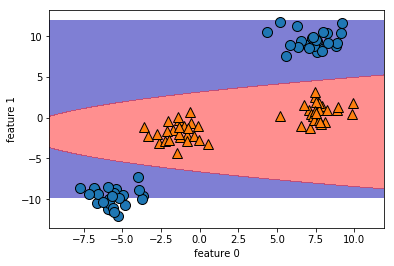

In [6]:
ZZ = YY ** 2
dec = linear_svm_3d.decision_function(np.c_[XX.ravel(), YY.ravel(), ZZ.ravel()])
plt.contourf(XX, YY, dec.reshape(XX.shape), levels=[dec.min(), 0, dec.max()], cmap=mglearn.cm2, alpha=.5)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel('feature 0')
plt.ylabel('feature 1')

#### 커널 기법
+ 새로운 특성을 만들지 않고 고차원 분류기를 학습시키는 방법

+ 데이터 특성이 많은 경우 어떤 특성을 수정할지 모르고 연산 비용이 커짐
+ 서포트 벡터 머신에서 데이터를 고차원 공간에 매핑하는 방법
  + 원래 특성의 가능한 조합을 지정된 차수까지 모두 계산 하는 다항식 커널
  + 가우시안 커널
    + 차원이 무한한 특성 공간에 매핑하는 것(모든 차수의 모든 다항식을 고려하는 방법 -> 지수함수의 테일러 급수 전개 때문)
  + 시그모이드 커널

#### SVM 이해하기
+ 일반적으로 훈련 데이터의 일부만 결정 경계를 만드는데 영향을 줌
+ 두 클래스 사이의 경계에 위치한 데이터 포인트 : 서포트 벡터
+ 새로운 데이터 포인트에 대해 예특하려면 각 서포트 벡터와의 거리를 측정함
  + 데이터 포인트 사이의 거리는 가우시안 커널에 의해 계산됨($k_{rbf}(x_1, x_2) = e^{(-\gamma \|x_1 - x_2\|^2)}$
  + $\|x_1 - x_2\|$는 유클리디안 거리 $\gamma$는 가우시안 커널의 폭을 제어하는 매개변수

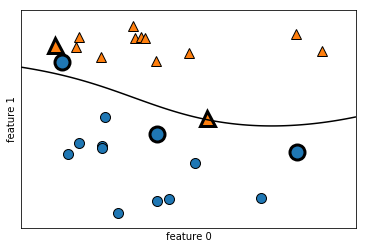

In [8]:
from sklearn.svm import SVC
X, y = mglearn.tools.make_handcrafted_dataset()
svm = SVC(kernel='rbf', C=10, gamma=.1).fit(X, y)

mglearn.plots.plot_2d_separator(svm, X, eps=.5)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
# 서포트 벡터
sv = svm.support_vectors_

sv_labels = svm.dual_coef_.ravel() > 0
mglearn.discrete_scatter(sv[:, 0], sv[:, 1], sv_labels, s=15, markeredgewidth=3)
plt.xlabel('feature 0')
plt.ylabel('feature 1')

##### KSVM 매개변수 튜닝
gamma($\gamma$) : 가우시안 커널 폭의 역수, 하나의 훈련 샘플이 미치는 영향의 범위, gamma가 커지면 영향이 줄어듦  
C : 규제 변수, 포인트의 중요도 제한, C가 증가하면 모델에 큰 영향을 주며 결정 경계를 휘어서 정확하게 분류함(과대적합 될 수도 있음)

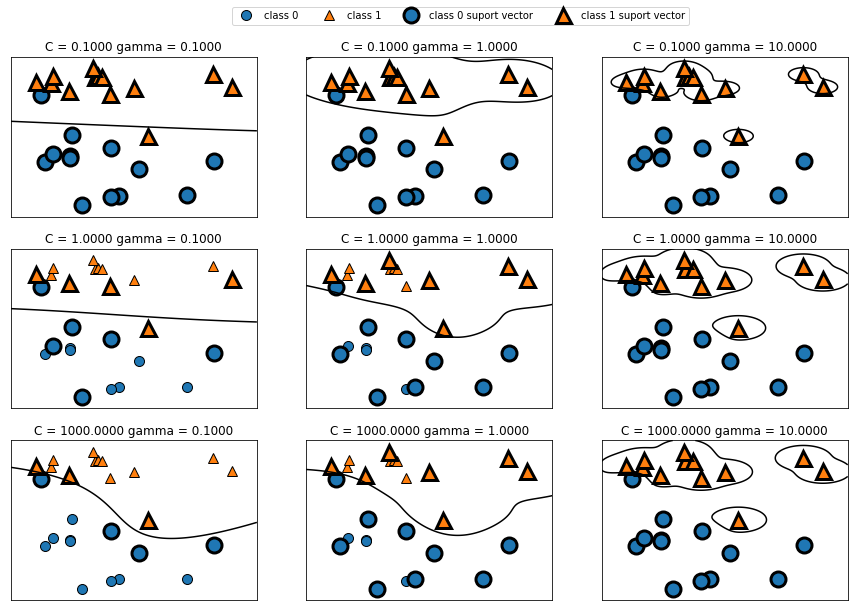

In [10]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10))

for ax, C in zip(axes, [-1, 0, 3]):
    for a, gamma in zip(ax, range(-1, 2)):
        mglearn.plots.plot_svm(log_C=C, log_gamma=gamma, ax=a)

axes[0, 0].legend(['class 0', 'class 1', 'class 0 suport vector', 'class 1 suport vector'], ncol=4, loc=(.9, 1.2))

+ RBF KSVM을 유방암 데이터셋에 적용(C=1, gamma=1/n_features)

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)

svc = SVC()
svc.fit(X_train, y_train)

print("훈련 세트 정확도 : {:.2f}".format(svc.score(X_train, y_train)))
print("테스트 세트 정확도 : {:.2f}".format(svc.score(X_test, y_test)))

훈련 세트 정확도 : 1.00
테스트 세트 정확도 : 0.63


상당히 과대적합 되었음, 매개변수 설정과 데이터 스케일에 매우 민감함

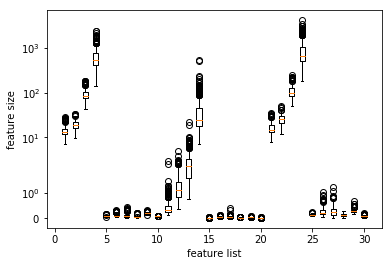

In [18]:
plt.boxplot(X_train, manage_xticks=False)
plt.yscale('symlog')
plt.xlabel('feature list')
plt.ylabel('feature size')

유방암 데이터셋의 특성은 자릿수 자체가 완정히 다름  
KSVM은 자릿수에 민감함

#### SVM을 위한 데이터 전처리

특성 값의 번위가 비슷해지도록 조정하는것이 중요  
KSVM에서는 모든 특성값을 0과 1사이로 맞추는 방법을 많이 사용

In [38]:
# 훈련 세트에서 특성 최솟값 곗산
min_on_training = X_train.min(axis=0)
# 훈련 세트에서 특성별 (최댓값 - 최솟값) 범위 계산
range_on_training = (X_train - min_on_training).max(axis=0)

# 훈현 데이터에 최솟값을 빼고 범위로 나누면
# 각 특성에 대해 최솟값은 0, 최댓값은 1
X_train_scaled = (X_train - min_on_training) / range_on_training
print('특성별 최소 값 \n{}'.format(X_train_scaled.min(axis=0)))
print('특성별 최대 값 \n{}'.format(X_train_scaled.max(axis=0)))

# 테스트 세트에서도 같은 작업을 적용하지만
# 훈련 세트에서 계산한 최솟값과 범위를 사용함
X_test_scaled = (X_test - min_on_training) / range_on_training

svc = SVC()
svc.fit(X_train_scaled, y_train)

print("훈련 세트 정확도 : {:.3f}".format(svc.score(X_train_scaled, y_train)))
print("테스트 세트 정확도 : {:.3f}".format(svc.score(X_test_scaled, y_test)))

특성별 최소 값 
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
특성별 최대 값 
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
훈련 세트 정확도 : 0.948
테스트 세트 정확도 : 0.951


+ 테스트 세트의 정확도는 높아졌지만 과소 적합된 상태  
  + C, gamma값을 증가 시켜 좀더 복잡한 모델을 만듦

In [39]:
svc = SVC(C=1000)
svc.fit(X_train_scaled, y_train)
print("훈련 세트 정확도 : {:.3f}".format(svc.score(X_train_scaled, y_train)))
print("테스트 세트 정확도 : {:.3f}".format(svc.score(X_test_scaled, y_test)))

훈련 세트 정확도 : 0.988
테스트 세트 정확도 : 0.972


#### 장단점과 매개변수 

+ 장단점 
  + KSVM은 다양한 데이터셋에서 잘 작동함
  + 데이터의 특성이 몇 개 안 되더라도 복잡한 결정 경계를 만들 수 있음
  + 저차원과 고차원의 데이터에 모두 잘 작동 하지만 샘플이 많을 때는잘 맞지 않음
  + 전처리와 매개변수 설정에 신경을 많이 써야함
  + 분석이 어렵고 예측이 어떻게 결정되었는지 이해하기 어려움
  + 모든 특성이 비슷한 단위이고 스케일이 비슷하면 SVC을 시도해볼 만 함
+ 매개변수
  + gamma( γγ ) : 가우시안 커널 폭의 역수, 하나의 훈련 샘플이 미치는 영향의 범위, gamma가 커지면 영향이 줄어듦
  + C : 규제 변수, 포인트의 중요도 제한, C가 증가하면 모델에 큰 영향을 주며 결정 경계를 휘어서 정확하게 분류함(과대적합 될 수도 있음)